# SAT NETs relevant to the 2025 "Pivot to Chile", Phase 2

January 2025

This notebook calculates NETs for the "Phase 2" baseline SATs, and some variations on that.
The baseline model has:
1) a HWP, large enough to enable f/1.45 optics,
2) horn sizes about the same as SO, which coupled with the same f/# as SO, means that we roughly match the spillover and edge
taper of SO.

This modeling uses flat bands, and a single number for each band's spillover.

NETs are calculated per detector, per wafer, and "per tube", where horn-horn correlations, yield, the number of wafers/tube and the optically good fraction of detectors in a tube are all taken into account.

In [82]:
!pwd

/Users/ruhl/code/bolo_calc_runs/jbolo/2025


In [103]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
from jbolo_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8, 4]

In [104]:
# List what yaml files you have so you can choose one for the next line.
!ls -lt1 yamls 

Bicep3_90GHz.yaml
SAT_HWP_aggr_20250126_thinwindow.yaml
SAT_HWP_aggr_20241121_phase2.yaml


# Compare windows
Three options here:
- CMB-S4 baseline, 20mm thick with tandelta = 3e-4
- Bicep3 inspired tandelta, 20mm thick with tandelta = 1.2e-4
- Bicep3 inspired dyneema; 1.4mm thick, tandelta = 2.4e-4

In [141]:
# Dictionary of models to use, which includes yaml file for now, but will have results in it later.
SAT_models = {}

# Thick (20mm) window, tandelta = 3e-4
SAT_models['Chile_phase2']={  
    'yaml':'SAT_HWP_aggr_20241121_phase2.yaml',
    'window_thickness': 0.020,
    'window_tandelta': 3.0e-4
}

# Thick (20mm) window, tandelta = 1.2e-4
SAT_models['Chile_phase2_tandelta1p2']={  
    'yaml':'SAT_HWP_aggr_20241121_phase2.yaml',
    'window_thickness': 0.020,
    'window_tandelta': 1.2e-4
}

# Thin (1.4mm dyneema) window
SAT_models['Chile_phase2_thinwindow']={ 
    'yaml':'SAT_HWP_aggr_20241121_phase2.yaml',
    'window_thickness': 0.0014,
    'window_tandelta': 2.4e-4

}


We're going to do this a very simple way, where we explicitly run each sim and plot it before moving on to the next.


In [142]:
models = ['Chile_phase2', 'Chile_phase2_tandelta1p2', 'Chile_phase2_thinwindow']

uhmwpe_tandelta = 1.2e-4
dyneema_tandelta = 2.4e-4

sims={}
# Run each model
for model in models:
    # Set up
    yamlfile = 'yamls/'+SAT_models[model]['yaml']
    sim = yaml.safe_load(open(yamlfile))
    sim['optical_elements']['window']['loss_tangent'] = SAT_models[model]['window_tandelta']
    sim['optical_elements']['window']['thickness']    = SAT_models[model]['window_thickness']
    SAT_models[model]['comment'] = 'NETs are in uKrtsec; powers are in pW'
    SAT_models[model]['name'] = model #sim['version']['name']
    SAT_models[model]['date'] = sim['version']['date']
    SAT_models[model]['site'] = sim['sources']['atmosphere']['site']
    SAT_models[model]['pwv'] = sim['sources']['atmosphere']['pwv']
    SAT_models[model]['elev'] = sim['sources']['atmosphere']['elevation']
    SAT_models[model]['wafers'] = sim['bolo_config']['num_wafers_per_tube']
    SAT_models[model]['optically_good_fraction'] = sim['bolo_config']['optically_good_det_fraction']
    
    # Run
    run_optics(sim)
    run_bolos(sim)
    #print_optics(sim,'MF_1_1')
 
    # Pack outputs into the models dictionary
    SAT_models[model]['channels']=sim['outputs'].keys()
    ii = 0
    for ch in SAT_models[model]['channels']:
        SAT_models[model][ch]={}
        net1det = 1e6*sim['outputs'][ch]['NET_C_total']  # use the version with horn-horn correlations
        ndet = sim['channels'][ch]['num_det_per_wafer']  # detectors per wafer
        net_wafer = net1det/np.sqrt(ndet*sim['bolo_config']['yield'])  #Take yield into account, usually 80%
        net_tube = net_wafer/np.sqrt(SAT_models[model]['wafers']*SAT_models[model]['optically_good_fraction'])  #Take yield into account, usually 80%
        ms = 1/net_tube**2
        SAT_models[model][ch]['P_opt'] = 1e12*sim['outputs'][ch]['P_opt']   #convert to pW from W
        SAT_models[model][ch]['NET_wafer'] = net_wafer   #convert to uKrtsec from Krtsec
        SAT_models[model][ch]['NET_tube'] = net_tube
        SAT_models[model][ch]['mapping_speed'] = ms
        SAT_models[model][ch]['NET_C'] = net1det
        SAT_models[model][ch]['corr_factor'] = sim['outputs'][ch]['corr_factor']
        SAT_models[model][ch]['NET_NC']=1e6*sim['outputs'][ch]['NET_NC_total']
        chnum = sim['channels'][ch]['chnum']
        SAT_models[model][ch]['Lyot_abs'] = sim['optical_elements']['lyot']['absorption'][chnum]
        ii += 1
        
# Print a table for each model
for model in models:
    print(SAT_models[model]['name'], end=', ')
    print(SAT_models[model]['site'], end=', ')
    print('pwv =',SAT_models[model]['pwv'],'u', end=', ')
    print('elev =',SAT_models[model]['elev'])
    #print('            NET_NC   corr_fact NET_C    NET_wafer  NET_tube map_speed  ms_ratio     P_opt')
    print('            NET_NC   ms_ratio     P_opt')
    for ch in SAT_models[model]['channels']:
        msratio = SAT_models[model][ch]['mapping_speed']/SAT_models['Chile_phase2'][ch]['mapping_speed']
        print(ch.ljust(10),end='')
#        print('{0:8.1f}  {1:8.3f} {2:8.1f}  {3:8.1f} {4:8.2f}  {5:10.2e}  {6:8.2f} {7:10.2f}'.format(SAT_models[model][ch]['NET_NC'], 
#                                                                                           SAT_models[model][ch]['corr_factor'],
#                                                                                           SAT_models[model][ch]['NET_C'],
#                                                                                           SAT_models[model][ch]['NET_wafer'], 
#                                                                                           SAT_models[model][ch]['NET_tube'],
#                                                                                           SAT_models[model][ch]['mapping_speed'],
#                                                                                           msratio,
#                                                                                           SAT_models[model][ch]['P_opt']))
        print('{0:8.1f}  {1:8.2f} {2:10.2f}'.format(SAT_models[model][ch]['NET_NC'], 
                                                    msratio,
                                                    SAT_models[model][ch]['P_opt']))

    print()
    
    

Chile_phase2, Atacama, pwv = 993 u, elev = 50
            NET_NC   ms_ratio     P_opt
LF_1         214.1      1.00       0.28
LF_2         147.5      1.00       1.28
MF_1_1       268.3      1.00       1.39
MF_2_1       245.1      1.00       1.57
MF_1_2       305.3      1.00       3.80
MF_2_2       343.2      1.00       4.57
HF_1         719.6      1.00      11.23
HF_2        1816.9      1.00      14.66

Chile_phase2_tandelta1p2, Atacama, pwv = 993 u, elev = 50
            NET_NC   ms_ratio     P_opt
LF_1         202.9      1.12       0.26
LF_2         137.4      1.16       1.18
MF_1_1       241.4      1.24       1.21
MF_2_1       215.1      1.30       1.32
MF_1_2       254.8      1.45       3.03
MF_2_2       287.5      1.43       3.67
HF_1         601.6      1.43       9.12
HF_2        1538.9      1.39      12.24

Chile_phase2_thinwindow, Atacama, pwv = 993 u, elev = 50
            NET_NC   ms_ratio     P_opt
LF_1         196.5      1.19       0.25
LF_2         131.6      1.26       1.

Look at how the baseline model changes if you change the HWP thickness, as appropriate for MF and LF.

In [143]:
yamlfile = 'yamls/'+SAT_models['Chile_phase2']['yaml']
sim = yaml.safe_load(open(yamlfile))

def print_myline(sim,label):
    print(label.rjust(22),': ',end='')
    for ch in sim['channels'].keys():
        msratio = (NET0[ch]/sim['outputs'][ch]['NET_NC_total'])**2
        print('{0:9.3f}'.format(msratio),end='  ')
    print('')

print('Mapping speed ratios, relative to 4.0mm HWP thickness')
print(' '.rjust(22),end='')
for ch in sim['channels'].keys():
    print(ch.rjust(11),end='')
print('')

# This is the current yaml
NET0 = {}
sim['optical_elements']['hwp']['thickness'] = 4.0e-3
run_optics(sim)
run_bolos(sim)
for ch in sim['channels'].keys():
    NET0[ch] = sim['outputs'][ch]['NET_NC_total']
    
# HF 
sim['optical_elements']['hwp']['thickness'] = 5.1e-3
run_optics(sim)
run_bolos(sim)
print_myline(sim,'5.1mm')


# MF 
sim['optical_elements']['hwp']['thickness'] = 11.25e-3
run_optics(sim)
run_bolos(sim)
print_myline(sim,'11.25mm')

# LF 
sim['optical_elements']['hwp']['thickness'] = 35.4e-3
run_optics(sim)
run_bolos(sim)
print_myline(sim,'35.4mm')


Mapping speed ratios, relative to 4.0mm HWP thickness
                             LF_1       LF_2     MF_1_1     MF_2_1     MF_1_2     MF_2_2       HF_1       HF_2
                 5.1mm :     0.996      0.995      0.992      0.990      0.986      0.987      0.986      0.987  
               11.25mm :     0.973      0.965      0.946      0.936      0.915      0.916      0.912      0.915  
                35.4mm :     0.888      0.859      0.791      0.757      0.689      0.692      0.677      0.680  


Text(0.5, 0, 'Band number, low to high freq')

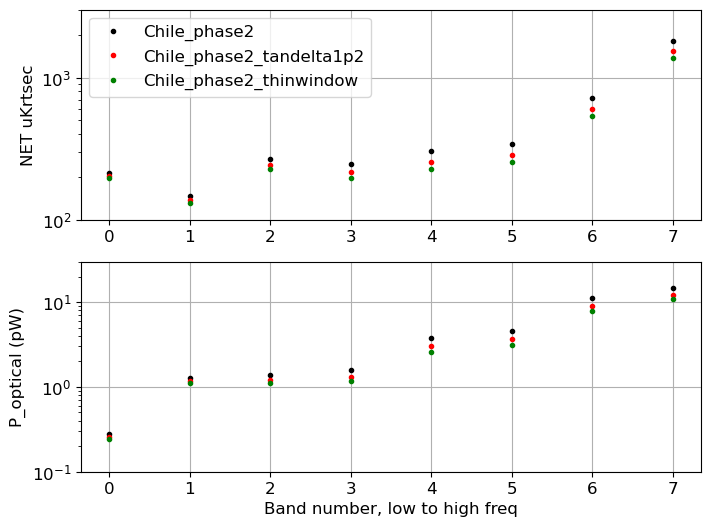

In [144]:
plt.rcParams['figure.figsize'] = [8, 6]
colors = ['black','red','green']
jj = 0
for model in SAT_models:
    color = colors[jj]
    ii = 0
    for ch in SAT_models[model]['channels']:

        plt.subplot(2,1,1)
        if ii==0:
            plt.semilogy(ii,SAT_models[model][ch]['NET_NC'],'.',color=color,label=model)
        else:
            plt.semilogy(ii,SAT_models[model][ch]['NET_NC'],'.',color=color)

        plt.subplot(2,1,2)
        if ii==0:
            plt.semilogy(ii,SAT_models[model][ch]['P_opt'],'.',color=color,label=model)
        else:
            plt.semilogy(ii,SAT_models[model][ch]['P_opt'],'.',color=color)
        ii += 1
    
    jj += 1

plt.subplot(2,1,1)
plt.grid()
plt.ylim(100,3000)
plt.legend()
plt.ylabel('NET uKrtsec')

plt.subplot(2,1,2)
plt.grid()
plt.ylim(0.1,30)
plt.ylabel('P_optical (pW)')
plt.xlabel('Band number, low to high freq')
    

Text(0.5, 0, 'Band number, low to high freq')

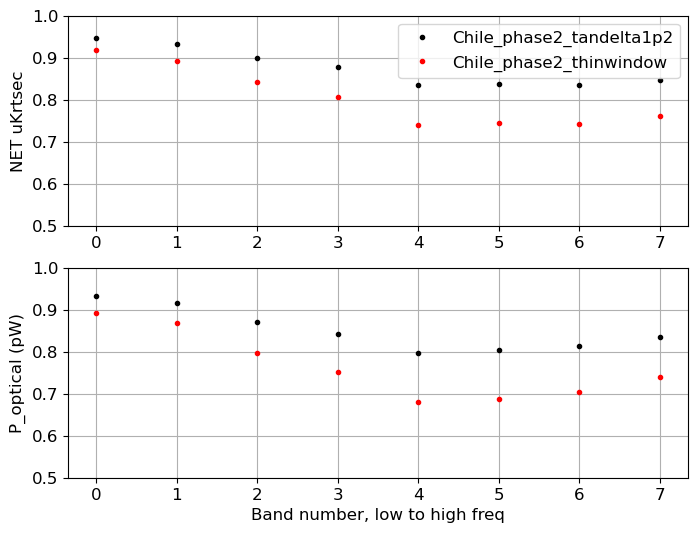

In [148]:
plt.rcParams['figure.figsize'] = [8, 6]
colors = ['black','red','green']
jj = 0
ref_model = 'Chile_phase2'
for model in ['Chile_phase2_tandelta1p2', 'Chile_phase2_thinwindow']:
    color = colors[jj]
    ii = 0
    for ch in SAT_models[model]['channels']:

        net_ratio = SAT_models[model][ch]['NET_NC']/SAT_models[ref_model][ch]['NET_NC']
        Popt_ratio = SAT_models[model][ch]['P_opt']/SAT_models[ref_model][ch]['P_opt']
        
        plt.subplot(2,1,1)
        if ii==0:
            plt.plot(ii,net_ratio,'.',color=color,label=model)
        else:
            plt.plot(ii,net_ratio,'.',color=color)

        plt.subplot(2,1,2)
        if ii==0:
            plt.plot(ii,Popt_ratio,'.',color=color,label=model)
        else:
            plt.plot(ii,Popt_ratio,'.',color=color)
        ii += 1
    
    jj += 1

plt.subplot(2,1,1)
plt.legend()
plt.grid()
plt.ylim(0.5,1.0)
plt.ylabel('NET uKrtsec')

plt.subplot(2,1,2)
plt.grid()
plt.ylim(0.5, 1.0)
plt.ylabel('P_optical (pW)')
plt.xlabel('Band number, low to high freq')

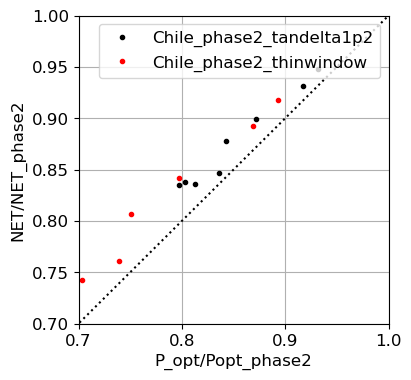

In [147]:
jj=0
for model in ['Chile_phase2_tandelta1p2', 'Chile_phase2_thinwindow']:
    color = colors[jj]
    ii = 0
    for ch in SAT_models[model]['channels']:
        net_ratio = SAT_models[model][ch]['NET_NC']/SAT_models[ref_model][ch]['NET_NC']
        Popt_ratio = SAT_models[model][ch]['P_opt']/SAT_models[ref_model][ch]['P_opt']
        if ii==0:
            plt.plot(Popt_ratio, net_ratio,'.',color=color,label=model)
        else:
            plt.plot(Popt_ratio, net_ratio,'.',color=color)
        ii += 1
    jj += 1

plt.rcParams['figure.figsize'] = [4,4]
plt.legend()
plt.xlim(0.7,1)
plt.ylim(0.7,1)
plt.plot([0,1],[0,1],'k:')
plt.ylabel('NET/NET_phase2')
plt.xlabel('P_opt/Popt_phase2')
plt.grid()
        

# Look at a Bicep3 model and see if it reproduces loadings/NETs from that paper.

In [160]:
yamlfile = 'yamls/Bicep3_90GHz.yaml'
sim = yaml.safe_load(open(yamlfile))

run_optics(sim)
run_bolos(sim)

In [161]:
print_optics(sim,'MF_1')
print_full_table(sim)

MF_1
Element            Popt(pW)   Effic  Effic_cumul
detector       :    0.0000     0.5000    1.0000
lowpass        :    0.0000     0.9400    0.5000
lens2          :    0.0181     0.9307    0.4700
nylon_filt     :    0.0021     0.9840    0.4374
lens1          :    0.0130     0.9415    0.4304
lyot           :    0.0414     0.8700    0.4052
alumina_filt   :    0.1149     0.9615    0.3526
RTMLI_10       :    0.0736     0.9960    0.3390
window         :    0.3292     0.9863    0.3376
baffle         :    0.3041     0.9900    0.3330
atmosphere     :    1.3619     0.9499    0.3297
cmb            :    0.1207     0.0000    0.3132
P_opticsonly_total = 8.9639e-13
P_optical_total =  2.3790e-12
20250210 : Bicep3
                             MF_1       MF_2
        det_bandcenter :    96.050    149.950  
         det_bandwidth :    26.700     37.400  
        sys_bandcenter :    95.975    149.802  
         sys_bandwidth :    26.254     36.528  
        sky_bandcenter :    95.964    149.811  
     